In [ ]:
# Importing libraries
# Data processing operations
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np
from itertools import product
#from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Handling warnings
import warnings
warnings.filterwarnings('ignore')

# Loading datasets from google drive
import os

# Clean the memory
import gc


In [ ]:
# Storing the files in dataframes from dictionary dataframes
color_sales_df = pd.read_excel("Tshirt_Sales_Data_Reformatted_Newcolor.xlsx",sheet_name="Sheet1")
# Shape of the dataframes
print("Color Sales Dataframe:",color_sales_df.shape)

Color Sales Dataframe: (1446, 6)


In [ ]:
color_sales_df['Color'].nunique()

44

In [ ]:
# Split our dataset into train and test
# Train: 2021 to 2023
# Test: 2024
# Train at color level, as it has many data points
# Validation/ Test at color level

In [ ]:
color_sales_df['Cluster'].unique()

array(['Cool Pastels', 'Bold Accents', 'Bright and Vibrant Shades', nan,
       'Core Neutrals', 'Warm Earth Tones', 'Cool Earth Tones',
       'Rich Darks'], dtype=object)

In [ ]:
color_sales_df.describe(include='all')

,Year,Season,Month,Color,Cluster,Sales
count,1446.000000,1446,1446,1446,1350,1446.000000
unique,NaN,2,12,44,7,NaN
top,NaN,Winter,Jul,Dark Green,Core Neutrals,NaN
freq,NaN,726,121,72,336,NaN
mean,2022.506224,NaN,NaN,NaN,NaN,158.447441
std,1.120258,NaN,NaN,NaN,NaN,85.863751
min,2021.000000,NaN,NaN,NaN,NaN,56.000000
25%,2022.000000,NaN,NaN,NaN,NaN,81.000000
50%,2023.000000,NaN,NaN,NaN,NaN,121.000000
75%,2024.000000,NaN,NaN,NaN,NaN,242.000000


In [ ]:
# Replace nan as Unknown in cluster column
color_sales_df['Cluster'] = color_sales_df['Cluster'].fillna('Unknown')

In [ ]:
# Split of dataset into train and test
train = color_sales_df[color_sales_df['Year']<2024]
test = color_sales_df[color_sales_df['Year']==2024]

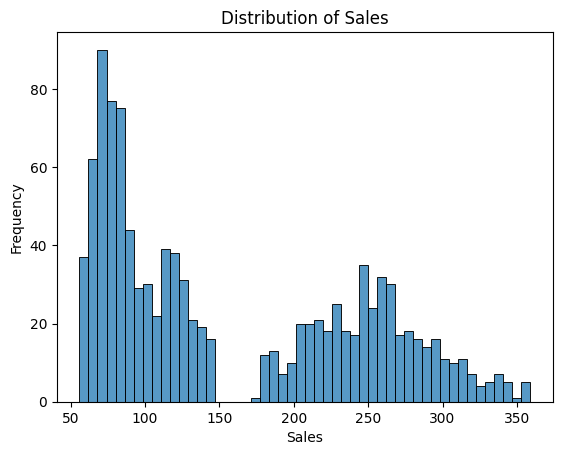

In [ ]:
# Distribution of units_sold
sns.histplot(train['Sales'],bins=50)
plt.title('Distribution of Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()



In [ ]:
# Map months to ordinal values
train_one_hot = pd.get_dummies(train[["Season","Month","Color","Cluster"]],dtype=int)
test_one_hot = pd.get_dummies(test[["Season","Month","Color","Cluster"]],dtype=int)
train_df = pd.concat([train,train_one_hot],axis=1)
test_df = pd.concat([test,test_one_hot],axis=1)
train_df.drop(["Season","Month","Color","Cluster"],axis=1,inplace=True)
test_df.drop(["Season","Month","Color","Cluster"],axis=1,inplace=True)

In [ ]:
# Splitting the train and test into X_train, X_test, y_train and y_test
X_train = train_df.drop(['Sales'],axis=1)
y_train = train_df['Sales']
X_test = test_df.drop(['Sales'],axis=1)
X_train = X_train.reindex(columns=X_test.columns,fill_value=0)
y_test = test_df['Sales']
# rename the sales column to actual_sales
y_test.name = 'actual_sales'

In [ ]:
print(X_train.shape)
print(X_test.shape)


(1080, 67)
(366, 67)


In [ ]:
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

# Step 5: Predict on test data
y_pred = model.predict(X_test)

# Step 6: Evaluate the model (optional)
#y_pred = model.predict(X_train)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on Training Data: {mse}")

Mean Squared Error on Training Data: 703.1205221615058


In [ ]:
# Forecasted Sales
test['Forecasted_Sales'] = y_pred

In [ ]:
test

,Year,Season,Month,Color,Cluster,Sales,Forecasted_Sales
1080,2024,Summer,Jan,Red,Bold Accents,73,76.500000
1081,2024,Summer,Jan,Teal,Cool Earth Tones,83,63.000000
1082,2024,Summer,Jan,Cyan,Bold Accents,68,67.000000
1083,2024,Summer,Jan,Green,Unknown,84,60.000000
1084,2024,Summer,Jan,Coral,Bright and Vibrant Shades,61,68.000000
...,...,...,...,...,...,...,...
1441,2024,Winter,Aug,Violet,Rich Darks,66,86.000000
1442,2024,Winter,Sep,Violet,Rich Darks,83,94.000000
1443,2024,Winter,Oct,Violet,Rich Darks,110,240.000000
1444,2024,Winter,Nov,Violet,Rich Darks,220,202.666667


In [ ]:
test.to_csv("forecasted_sales.csv",index=False)

In [ ]:
#total_forecasted_sales = test['Forecasted_Sales'].sum()
violet_sales = test[test['Color'] == 'Violet']['Forecasted_Sales'].sum()

color_sales = test.groupby('Color')['Forecasted_Sales'].sum()
other_colors_sales = color_sales.drop('Violet', errors='ignore')
total_other_sales = other_colors_sales.sum()
other_colors_percentage = (other_colors_sales / total_other_sales) * 100
violet_percentage = (violet_sales / test['Forecasted_Sales'].sum()) * 100



In [ ]:
color_share_percentage = pd.concat([other_colors_percentage, pd.Series({'Violet': violet_percentage})])
# Normalize percentages (optional, for rounding adjustments)
color_share_percentage = (color_share_percentage / color_share_percentage.sum()) * 100
color_share_percentage = color_share_percentage.reset_index()
color_share_percentage.columns = ['Color', 'Color_Share_Percentage']
color_share_percentage['Color_Share_Percentage'] = color_share_percentage['Color_Share_Percentage'].round(2)

In [ ]:
color_share_percentage

,Color,Color_Share_Percentage
0,Aqua,1.90
1,Ash,1.54
2,Beige,2.83
3,Black,3.27
4,Brown,1.49
5,Burgundy,1.53
6,Charcoal,2.86
7,Chestnut,1.44
8,Coral,3.56
9,Cyan,3.62


In [ ]:
pd.merge(test[['Color','Cluster']],color_share_percentage,on='Color',how='right').drop_duplicates().to_csv("Forecasted_Color_share_percentage.csv",index=False)

In [ ]:
# Step 1: Group by Cluster and sum the Forecasted Sales
cluster_sales = test.groupby('Cluster')['Forecasted_Sales'].sum().reset_index()

# Step 2: Calculate the total forecasted sales for the entire dataset
total_forecasted_sales = test['Forecasted_Sales'].sum()

# Step 3: Calculate the percentage of forecasted sales for each cluster
cluster_sales['Forecasted_Sales_Percentage'] = (cluster_sales['Forecasted_Sales'] / total_forecasted_sales) * 100

# Display the result
print(cluster_sales)

                     Cluster  Forecasted_Sales  Forecasted_Sales_Percentage
0               Bold Accents            6458.0                    11.335592
1  Bright and Vibrant Shades           11760.0                    20.642081
2           Cool Earth Tones            5263.0                     9.238033
3               Cool Pastels            6334.0                    11.117937
4              Core Neutrals           12268.0                    21.533763
5                 Rich Darks            3273.0                     5.745028
6                    Unknown            3586.0                     6.294430
7           Warm Earth Tones            8029.0                    14.093135


In [ ]:
# Historical sales
historical_sales = train.groupby(['Cluster'])['Sales'].sum().reset_index()

# Total sales for each cluster
total_sales = historical_sales['Sales'].sum()

# Step 3: Calculate the percentage of forecasted sales for each cluster
historical_sales['Historical_Cluster_Sales_Percentage'] = (historical_sales['Sales'] / total_sales) * 100

# Display the result
#print(historical_sales)

cluster_df = pd.merge(cluster_sales,historical_sales,on='Cluster',how='left')
cluster_df

,Cluster,Forecasted_Sales,Forecasted_Sales_Percentage,Sales,Historical_Sales_Percentage
0,Bold Accents,6458.0,11.335592,19346,11.267327
1,Bright and Vibrant Shades,11760.0,20.642081,35483,20.665696
2,Cool Earth Tones,5263.0,9.238033,15707,9.147932
3,Cool Pastels,6334.0,11.117937,19240,11.205591
4,Core Neutrals,12268.0,21.533763,37105,21.610367
5,Rich Darks,3273.0,5.745028,10018,5.834595
6,Unknown,3586.0,6.294430,10541,6.139196
7,Warm Earth Tones,8029.0,14.093135,24260,14.129295


In [ ]:
historical_color_sales = train.groupby(['Cluster','Color'])['Sales'].sum().reset_index()
# Total sales for each cluster
total_color_sales = historical_sales['Sales'].sum()
historical_color_sales['Historical_color_Sales_Percentage'] = (historical_color_sales['Sales'] / total_color_sales) * 100

forecast_color_sales = test.groupby(['Cluster','Color'])['Forecasted_Sales'].sum().reset_index()
total_forecasted_sales = test['Forecasted_Sales'].sum()

# Step 3: Calculate the percentage of forecasted sales for each cluster
forecast_color_sales['Forecasted_color_Sales_Percentage'] = (forecast_color_sales['Forecasted_Sales'] / total_forecasted_sales) * 100
df_merged = pd.merge(df_colors, df_clusters[['Cluster', 'Forecasted_Sales']], on='Cluster')


,Cluster,Color,Sales
0,Bold Accents,Cyan,6483
1,Bold Accents,Orange,3178
2,Bold Accents,Purple,3212
3,Bold Accents,Red,6473
4,Bright and Vibrant Shades,Aqua,3383


In [ ]:
df_merged = pd.merge(df_colors, final_df, on='Cluster')
df_merged['Forecasted_Sales_Per_Color'] = df_merged['Forecasted_Sales'] * (df_merged['Historical_Sales_Percentage'] / 100)

,Cluster,Color,Sales_x,Forecasted_Sales,Forecasted_Sales_Percentage,Sales_y,Historical_Sales_Percentage,Category
0,Bold Accents,Cyan,6483,6458.0,11.335592,19346,11.267327,Fashion
1,Bold Accents,Orange,3178,6458.0,11.335592,19346,11.267327,Fashion
2,Bold Accents,Purple,3212,6458.0,11.335592,19346,11.267327,Fashion
3,Bold Accents,Red,6473,6458.0,11.335592,19346,11.267327,Fashion
4,Bright and Vibrant Shades,Aqua,3383,11760.0,20.642081,35483,20.665696,Fashion
5,Bright and Vibrant Shades,Coral,6452,11760.0,20.642081,35483,20.665696,Fashion
6,Bright and Vibrant Shades,Lime,3257,11760.0,20.642081,35483,20.665696,Fashion
7,Bright and Vibrant Shades,Mint,6375,11760.0,20.642081,35483,20.665696,Fashion
8,Bright and Vibrant Shades,Peach,3292,11760.0,20.642081,35483,20.665696,Fashion
9,Bright and Vibrant Shades,Sky Blue,6447,11760.0,20.642081,35483,20.665696,Fashion
